## Clustering Project: Drivers of Error in Zillow Zestimates

Data Science Team Members: Gabby Broussard and Barbara Marques

#### Project Summary:

Our team has been asked to analyze Zillow data on single unit/single family properties with transaction dates in 2017 to discover the drivers of errors in Zillow's zestimates. 

Data Source: Zillow database on Codeup's data server.

#### Project Goals:
- Build out caching in your python scripts to store the data locally as a csv in order to speed up future data acquisition.
- Deliver a notebook presentation of methods used to isolate drivers of error in Zillow Zestimates

#### Initial Questions: 



<a id='back'></a>
### Quick Links to Sections within this Notebook

- [Acquire Data](#AD)
- [Prepare Data](#PD)
- [Split Data](#SD)
- [Explore Data](#Explore)
- [Hypothesis Testing](#Hypo)
- [Scale Data](#Scale)
- [Create a Baseline Model](#Baseline)
- [Model Data (train & validate)](#Model)
- [Model on Test Data](#Test)
- [Model Visualizations](#Visual)
- [Recommendations & Key Takeaways](#Concl)

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import wrangle
from acquire import get_zillow_data
# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#Modeling Imports
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans, dbscan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.max_columns', 80)

<a id='AD'></a>
## Acquire
[back to top](#back)

In [2]:
acquired_zillow =get_zillow_data()

In [3]:
acquired_zillow.shape

(52519, 69)

In [4]:
acquired_zillow.describe()

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror,buildingclassdesc
count,52519.000000,5.251900e+04,5.251900e+04,13646.000000,70.00000,47.000000,52519.000000,52519.000000,0.0,33797.000000,52368.000000,390.0,4386.000000,52424.000000,52257.000000,2.000000,0.0,4386.000000,165.000000,52519.000000,7242.000000,52368.000000,18020.000000,18020.000000,1515.0,33941.000000,5.251900e+04,5.251900e+04,5.214300e+04,11097.0,867.000000,444.0,1071.0,10010.0,52519.000000,5.251900e+04,51482.000000,52519.000000,19042.000000,52493.000000,52519.000000,47.0,6724.000000,76.000000,33906.000000,1938.000000,65.000000,52390.000000,14566.000000,81.0,5.243400e+04,5.251800e+04,52519.0,5.251700e+04,52515.000000,2082.000000,5.239600e+04,52519.000000,0.0
mean,26259.000000,1.497296e+06,1.299523e+07,2.437198,7.10000,678.978723,2.298501,3.299301,NaN,6.265822,2.304442,66.0,1545.784770,1922.539753,1924.719865,1180.000000,NaN,1566.524852,1241.078788,6049.129172,1.209887,2.239364,1.949057,495.692286,1.0,3.965941,3.402308e+07,-1.181944e+08,1.147545e+04,1.0,518.318339,1.0,1.0,1.0,261.003161,6.049441e+07,33484.448098,2524.974276,180224.457305,96636.445717,1.891335,7.0,1.013682,5.973684,1.000914,337.639319,229.738462,1963.431342,1.413703,1.0,1.963956e+05,5.292600e+05,2016.0,3.331849e+05,6448.593305,14.101825,6.050236e+13,0.018399,NaN
std,15161.073731,8.593969e+05,3.346503e+06,3.845206,2.66567,711.825226,1.022770,0.950309,NaN,1.715640,1.017415,0.0,674.796434,1003.888681,1003.805719,169.705627,NaN,744.380228,776.959074,21.031775,0.512915,0.992655,0.550025,157.324083,0.0,2.562413,2.743537e+05,3.567456e+05,8.693414e+04,0.0,156.468209,0.0,0.0,0.0,0.081574,2.087140e+05,49142.244858,803.816694,159813.908476,4601.736601,3.144982,0.0,0.142616,0.229416,0.031184,249.957585,190.834702,23.145636,0.540627,0.0,2.541886e+05,7.514558e+05,0.0,5.701992e+05,8751.052765,2.393770,1.857672e+12,0.177740,NaN
min,0.000000,3.490000e+02,1.071186e+07,1.000000,2.00000,38.000000,0.000000,0.000000,NaN,1.000000,1.000000,66.0,184.000000,128.000000,128.000000,1060.000000,NaN,184.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,3.334062e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,261.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1878.000000,1.000000,1.0,1.290000e+02,1.000000e+03,2016.0,1.610000e+02,49.180000,4.000000,6.037101e+13,-4.655420,NaN
25%,13129.500000,7.578615e+05,1.150773e+07,1.000000,7.00000,263.500000,2.000000,3.000000,NaN,5.000000,2.000000,66.0,1151.000000,1268.000000,1270.000000,1120.000000,NaN,1152.000000,784.000000,6037.000000,1.000000,2.000000,2.000000,426.000000,1.0,2.000000,3.382713e+07,-1.184009e+08,5.584000e+03,1.0,424.500000,1.0,1.0,1.0,261.000000,6.037401e+07,12447.000000,1286.000000,41131.000000,96206.000000,0.000000,7.0,1.000000,6.000000,1.000000,200.000000,72.000000,1950.000000,1.000000,1.0,7.703800e+04,1.934172e+05,2016.0,7.581500e+04,2652.090000,14.000000,6.037401e+13,-0.024629,NaN
50%,26259.000000,1.500862e+06,1.257572e+07,1.000000,7.00000,512.000000,2.000000,3.000000,NaN,6.000000,2.000000,66.0,1410.0

In [5]:
null_counts = acquired_zillow.isnull().sum().sort_values(ascending=False)
null_counts

finishedsquarefeet15    52519
buildingclassdesc       52519
buildingclasstypeid     52519
finishedsquarefeet13    52517
storydesc               52472
                        ...  
assessmentyear              0
logerror                    0
transactiondate             0
propertylandusedesc         0
Unnamed: 0                  0
Length: 69, dtype: int64

### Takeaways:
##### There are numerous null values that need to be handled
#### Columns with too many nulls need to be dropped from the data frame.
##### There are many outliers so they either need to be removed or handled by using a RobustScaler when scaling the data.

<a id='PD'></a>
## Prepare

[back to top](#back)

In [6]:
df= wrangle.wrangle_zillow()

In [7]:
df.head() 

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,logerror,age_bin,taxrate,acres,acres_bin,tax_value_bin,land_tax_value_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
0,2.0,3.0,2107.0,6037,34222559.0,-118617387.0,45.0,249655.0,624139.0,374484.0,7659.36,-0.007357,40-50,1.227188,0.210239,0.2,"$650,000","$450,000",0.5,118.488372,0.4,40.891461,20-49,0.666667,1
1,2.0,4.0,1882.0,6037,34220261.0,-118616409.0,45.0,253000.0,660000.0,407000.0,8123.91,0.021066,40-50,1.230895,0.207415,0.2,"$900,000","$450,000",0.4,134.431456,0.4,45.047039,20-49,0.500000,1
2,2.0,4.0,1882.0,6037,34222491.0,-118616854.0,45.0,257591.0,542923.0,285332.0,6673.24,0.077174,40-50,1.229132,0.224977,0.2,"$550,000","$350,000",0.4,136.870882,0.4,29.115510,20-49,0.500000,1
3,2.0,3.0,1477.0,6037,34221864.0,-118615739.0,57.0,57968.0,78031.0,20063.0,1116.46,-0.041238,50-60,1.430790,0.259068,0.3,"< $80,000","< $50,000",0.3,39.247123,0.1,1.777847,1,0.666667,1
4,2.0,4.0,1918.0,6037,34220619.0,-118615253.0,57.0,167869.0,415459.0,247590.0,5239.85,-0.009496,50-60,1.261220,0.258012,0.3,"$450,000","$250,000",0.4,87.522941,0.3,22.029540,20-49,0.500000,1


In [8]:
# look at the first 5 rows of our new dataframe, transposed
df.head().T

,0,1,2,3,4
bathrooms,2,2,2,2,2
bedrooms,3,4,4,3,4
square_feet,2107,1882,1882,1477,1918
fips,6037,6037,6037,6037,6037
latitude,3.42226e+07,3.42203e+07,3.42225e+07,3.42219e+07,3.42206e+07
longitude,-1.18617e+08,-1.18616e+08,-1.18617e+08,-1.18616e+08,-1.18615e+08
age,45,45,45,57,57
structure_tax_value,249655,253000,257591,57968,167869
tax_value,624139,660000,542923,78031,415459
land_tax_value,374484,407000,285332,20063,247590


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50819 entries, 0 to 52504
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   bathrooms                  50819 non-null  float64 
 1   bedrooms                   50819 non-null  float64 
 2   square_feet                50819 non-null  float64 
 3   fips                       50819 non-null  int64   
 4   latitude                   50819 non-null  float64 
 5   longitude                  50819 non-null  float64 
 6   age                        50819 non-null  float64 
 7   structure_tax_value        50819 non-null  float64 
 8   tax_value                  50819 non-null  float64 
 9   land_tax_value             50819 non-null  float64 
 10  taxamount                  50819 non-null  float64 
 11  logerror                   50819 non-null  float64 
 12  age_bin                    50819 non-null  category
 13  taxrate                    5081

In [10]:
#There are no remaining null values

df.isna().sum().sum()

2213

### Creating some new features:
- bins for: age, square feet
- tax rate
- bath/bed ratio:  (bathroom count / bedroom count)
- acres (lotsizesquarefeet/43560)
- dollar per square foot
- within city of Los Angeles


In [11]:
df.head().T

,0,1,2,3,4
bathrooms,2,2,2,2,2
bedrooms,3,4,4,3,4
square_feet,2107,1882,1882,1477,1918
fips,6037,6037,6037,6037,6037
latitude,3.42226e+07,3.42203e+07,3.42225e+07,3.42219e+07,3.42206e+07
longitude,-1.18617e+08,-1.18616e+08,-1.18617e+08,-1.18616e+08,-1.18615e+08
age,45,45,45,57,57
structure_tax_value,249655,253000,257591,57968,167869
tax_value,624139,660000,542923,78031,415459
land_tax_value,374484,407000,285332,20063,247590


In [12]:
df.describe()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,logerror,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,bath_bed_ratio,cola
count,50819.000000,50819.000000,50819.000000,50819.000000,5.081900e+04,5.081900e+04,50819.000000,5.081900e+04,5.081900e+04,5.081900e+04,50819.000000,50819.000000,50819.000000,50819.000000,50819.000000,50819.000000,50819.000000,50819.000000,50819.000000,50819.000000,50819.000000
mean,2.276658,3.295618,1890.062319,6049.209252,3.402170e+07,-1.181933e+08,53.868278,1.853605e+05,4.946598e+05,3.092994e+05,6030.211070,0.017939,1.325649,0.225383,0.167221,0.391562,89.394145,0.277207,47.249064,0.695263,0.221669
std,0.960735,0.907396,907.211533,21.128854,2.729947e+05,3.556319e+05,22.870087,1.929858e+05,5.035473e+05,3.610726e+05,5813.634981,0.173194,0.357192,0.477141,0.102003,0.184703,56.314263,0.145267,65.848993,0.233315,0.415374
min,1.000000,1.000000,500.000000,6037.000000,3.334062e+07,-1.194753e+08,1.000000,1.480000e+02,3.254000e+03,2.250000e+03,49.180000,-4.655420,0.009372,0.005418,0.000000,0.000000,0.039833,0.000000,0.027992,0.200000,0.000000
25%,2.000000,3.000000,1266.000000,6037.000000,3.382730e+07,-1.183965e+08,39.000000,7.678600e+04,1.915205e+05,7.383300e+04,2627.880000,-0.024702,1.164476,0.128214,0.100000,0.300000,54.614490,0.200000,9.283830,0.500000,0.000000
50%,2.000000,3.000000,1649.000000,6037.000000,3.402067e+07,-1.181515e+08,57.000000,1.300920e+05,3.688660e+05,2.155180e+05,4587.670000,0.006860,1.232678,0.156841,0.200000,0.400000,81.508781,0.300000,30.230741,0.666667,0.000000
75%,3.000000,4.000000,2275.000000,6059.000000,3.418606e+07,-1.179291e+08,67.000000,2.203090e+05,6.083525e+05,4.041860e+05,7225.280000,0.040263,1.366791,0.199415,0.200000,0.500000,112.338372,0.400000,59.610322,0.800000,0.000000
max,7.000000,7.000000,8909.000000,6111.000000,3.481877e+07,-1.175723e+08,139.000000,3.097672e+06,4.993132e+06,4.847224e+06,72122.200000,3.394544,9.805110,19.796350,0.700000,0.900000,1444.221106,0.900000,1604.525311,3.000000,1.000000


(array([2.000e+00, 0.000e+00, 1.400e+01, 1.600e+01, 1.100e+02, 4.791e+04,
        2.575e+03, 1.000e+02, 8.300e+01, 9.000e+00]),
 array([-4.65542038, -3.85042393, -3.04542749, -2.24043104, -1.4354346 ,
        -0.63043816,  0.17455829,  0.97955473,  1.78455118,  2.58954762,
         3.39454407]),
 <BarContainer object of 10 artists>)

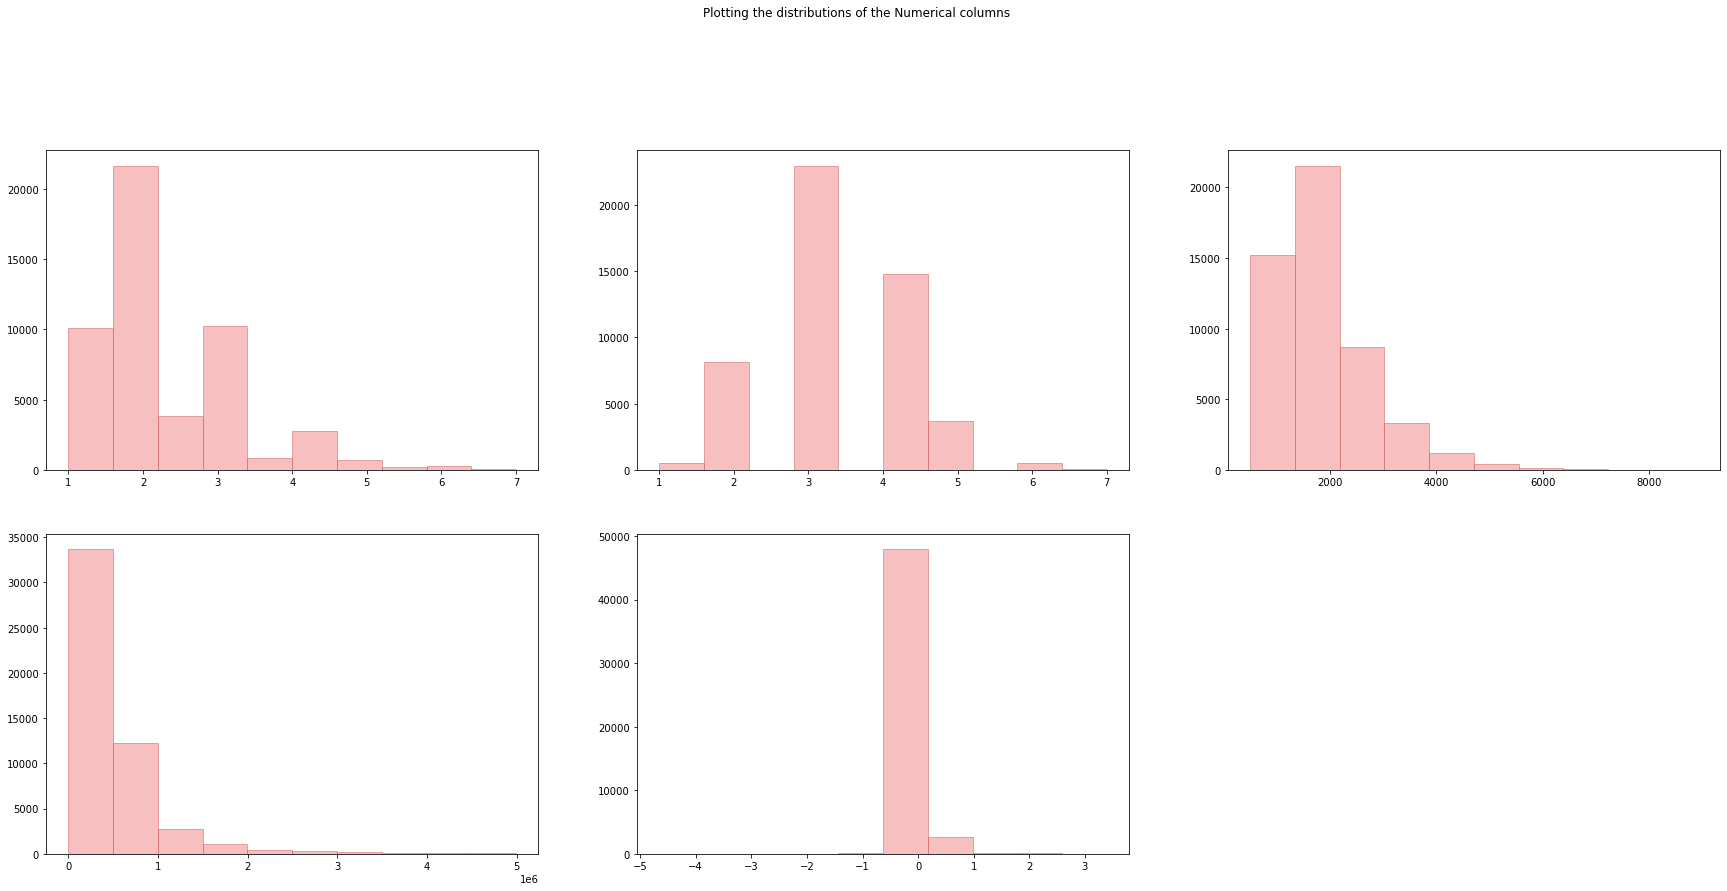

In [13]:
plt.figure(figsize=(30, 20))

plt.suptitle("Plotting the distributions of the Numerical columns")
# row, columns, index
plt.subplot(3, 3, 1)
plt.hist(df.bathrooms, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 2)
plt.hist(df.bedrooms, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 3)
plt.hist(df.square_feet, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 4)
plt.hist(df.tax_value, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 5)
plt.hist(df.logerror, edgecolor='indianred', alpha=0.5, color='lightcoral')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50819 entries, 0 to 52504
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   bathrooms                  50819 non-null  float64 
 1   bedrooms                   50819 non-null  float64 
 2   square_feet                50819 non-null  float64 
 3   fips                       50819 non-null  int64   
 4   latitude                   50819 non-null  float64 
 5   longitude                  50819 non-null  float64 
 6   age                        50819 non-null  float64 
 7   structure_tax_value        50819 non-null  float64 
 8   tax_value                  50819 non-null  float64 
 9   land_tax_value             50819 non-null  float64 
 10  taxamount                  50819 non-null  float64 
 11  logerror                   50819 non-null  float64 
 12  age_bin                    50819 non-null  category
 13  taxrate                    5081

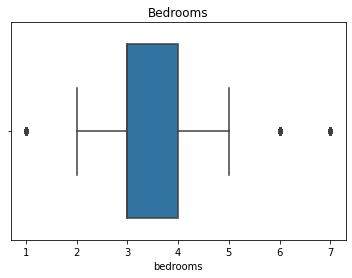

In [15]:
### Checking for Outliers:
sns.boxplot(df['bedrooms'])
plt.title('Bedrooms')
plt.show()

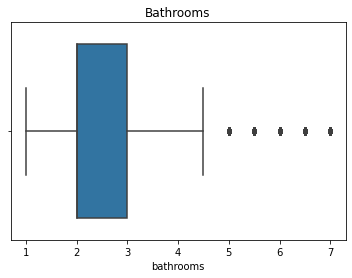

In [16]:
sns.boxplot(df['bathrooms'])
plt.title('Bathrooms')
plt.show()

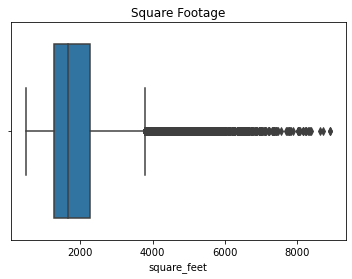

In [17]:
sns.boxplot(df['square_feet'])
plt.title('Square Footage')
plt.show()

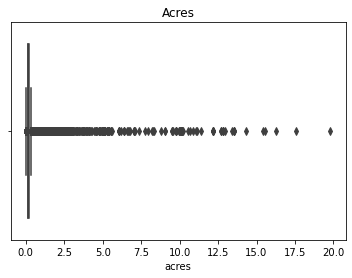

In [18]:
sns.boxplot(df['acres'])
plt.title('Acres')
plt.show()

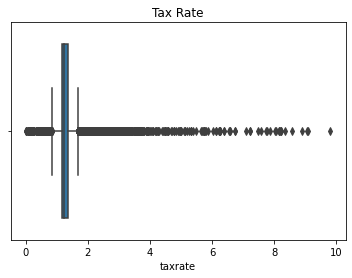

In [19]:
sns.boxplot(df['taxrate'])
plt.title('Tax Rate')
plt.show()

### Takeaways:  

Removing Outliers:

Remove extremes in bedrooms and baths (KEEP only 1-7 baths and 1-7 bedrooms)

remove square feet > 9000

remove lot size (acres) > 20 

Remove tax rate > 10% 

## Explore

<a id='SD'></a>
#### Splitting Data

[back to top](#back)

In [20]:
train_validate, test = train_test_split(df, test_size=.30, random_state=123)
train, validate = train_test_split(train_validate, test_size=.20, random_state=123)

print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (28458, 25)
validate observations:  (7115, 25)
test observations:  (15246, 25)


### Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Text(0.5, 1.0, 'County v. Log Error')

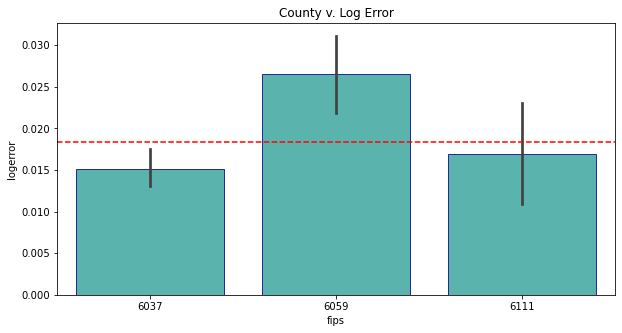

In [21]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.fips, train.logerror, data=train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('County v. Log Error')

### Hypothesis Testing - ANOVA

Ho: There is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County.
Ha: Logerror is significantly different among the counties of LA County, Orange County and Ventura County.

In [22]:
α = 0.05
F, p = stats.f_oneway(train.logerror[train.fips == 6111], train.logerror[train.fips == 6037], train.logerror[train.fips == 6059])
F, p

(11.928997011382128, 6.629382520331671e-06)

In [23]:
null_hypothesis = 'there is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County'

if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)


We reject the null hypothesis that there is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County


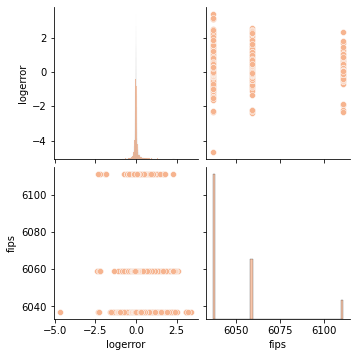

In [24]:
sns.set_palette("rocket_r")
sns.pairplot(train[['logerror', 'fips']])  

### Hypothesis Testing - Pearson R Correlation

First Hypothesis :  <br>
𝐻0: There is no difference in log error based on a properties square footage. <br>
𝐻𝑎: A properties square footage less than 2800 square footage have a lower log error than larger properties. 

In [25]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis = "there is no difference in log error based on a properties square footage."

In [26]:
x1 = train[train.square_feet >= 2800].logerror
x2 = train[train.square_feet < 2800].logerror

In [27]:
t, p= stats.ttest_ind(x1, x2)

In [28]:
if p >  α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We reject the null hypothesis that there is no difference in log error based on a properties square footage.


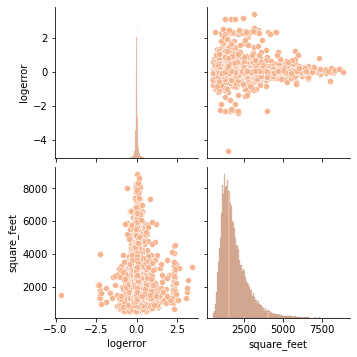

In [29]:
sns.set_palette("rocket_r")
sns.pairplot(train[['logerror', 'square_feet']])  

Text(0.5, 1.0, 'Acres v. Log Error')

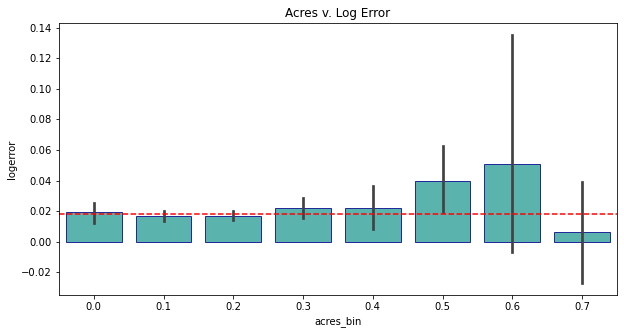

In [30]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.acres_bin, train.logerror, data=train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Acres v. Log Error')

Text(0.5, 1.0, 'Lot Dollar Per Square Footage v. Log Error')

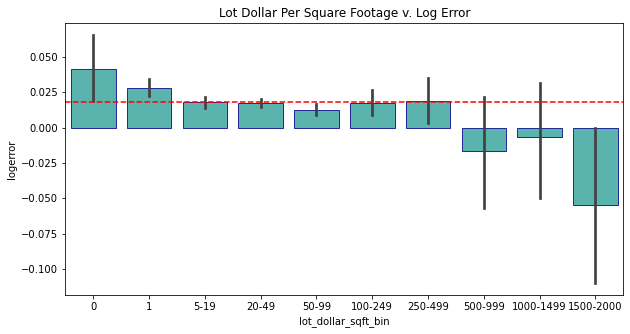

In [31]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.lot_dollar_sqft_bin, train.logerror, data=train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Lot Dollar Per Square Footage v. Log Error')

Text(0.5, 1.0, 'County v. Log Error')

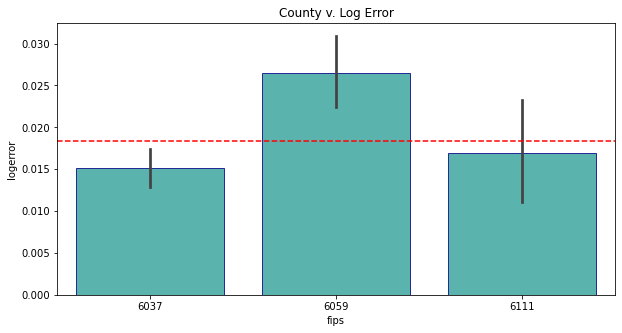

In [32]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.fips,train.logerror, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate =(train.logerror.mean())
p = plt.axhline(overall_rate, ls='--', color='red')
plt.title('County v. Log Error')

### Takeaways: 
- Hypothesis testing shows: There is a relationship between counties and log error.
- Hypothesis testing shows: There correlation between square footage and log error.
- Visualization shows: as dollar per square foot of land price increases, properties as a whole are undervalued by Zillow.
- Visualization shows: as acreage of land increases, properties as a whole are overvalued by Zillow.

## Clustering

### Split to create y_train, y_validate, y_test and Scale Data

In [33]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.data_split(df)

In [34]:
X_train.columns

Index(['bathrooms', 'bedrooms', 'square_feet', 'fips', 'latitude', 'longitude',
       'age', 'structure_tax_value', 'tax_value', 'land_tax_value',
       'taxamount', 'acres', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'bath_bed_ratio', 'cola'],
      dtype='object')

In [35]:
X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle.scaled_data(X_train, X_validate, X_test, y_train, y_validate, y_test)

## <font color = 'red'> Cluster on All Columns

In [36]:
X = X_train

# Make the kmeans object
kmeans = KMeans(n_clusters=4)

# fit the kmeans model
kmeans.fit(X)

# use the thing
kmeans.predict(X)

array([3, 0, 3, ..., 0, 1, 3], dtype=int32)

In [37]:
X_train.shape, X_validate.shape, X_test.shape

((28458, 16), (12197, 16), (10164, 16))

In [38]:
X_train.columns

Index(['bathrooms', 'bedrooms', 'square_feet', 'fips', 'latitude', 'longitude',
       'age', 'structure_tax_value', 'tax_value', 'land_tax_value',
       'taxamount', 'acres', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'bath_bed_ratio', 'cola'],
      dtype='object')

In [39]:
X_train["cluster_all"] = kmeans.predict(X)
X_validate['cluster_all'] = kmeans.predict(X_validate)
X_test['cluster_all'] = kmeans.predict(X_test)

In [40]:
X.head()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all
0,0.250000,0.333333,0.185293,0.297297,0.339753,0.875389,0.253623,0.054803,0.102699,0.084951,0.077757,0.004135,0.061088,0.069281,0.226190,0.0,3
1,0.166667,0.500000,0.099221,0.000000,0.521286,0.840746,0.442029,0.061590,0.081611,0.054661,0.069031,0.009516,0.105544,0.020281,0.107143,0.0,0
2,1.000000,0.666667,0.495617,0.000000,0.544098,0.421414,0.086957,0.382534,0.487622,0.315221,0.422423,0.016223,0.188555,0.069048,0.428571,0.0,3
3,0.333333,0.500000,0.327368,0.000000,0.438295,0.822033,0.253623,0.133445,0.093800,0.018039,0.080850,0.014902,0.094286,0.004400,0.196429,0.0,3
4,0.333333,0.500000,0.249087,0.000000,0.268795,0.597916,0.355072,0.093787,0.217836,0.196006,0.171504,0.011289,0.083007,0.061226,0.196429,0.0,3


In [41]:
X.cluster_all.value_counts()

0    11500
3     8180
1     6356
2     2422
Name: cluster_all, dtype: int64

In [42]:
cluster0 = X[X.cluster_all == 0]
cluster1 = X[X.cluster_all == 1]
cluster2 = X[X.cluster_all == 2]
cluster3 = X[X.cluster_all == 3]

In [43]:
cluster0.describe()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.0,11500.0
mean,0.164435,0.353333,0.135198,0.005946,0.532306,0.700325,0.415199,0.045046,0.066806,0.048619,0.060514,0.014432,0.061328,0.018899,0.158320,0.0,0.0
std,0.129637,0.137780,0.077483,0.041623,0.188472,0.102829,0.158761,0.033328,0.058325,0.055624,0.046531,0.032510,0.033697,0.026278,0.076719,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.253335,0.304893,0.000000,0.000041,0.002001,0.000201,0.000994,0.000980,0.000091,0.000021,0.000000,0.0,0.0
25%,0.000000,0.333333,0.079468,0.000000,0.385015,0.645640,0.326087,0.022775,0.027956,0.009853,0.029870,0.007687,0.038808,0.003210,0.107143,0.0,0.0
50%,0.166667,0.333333,0.117361,0.000000,0.486222,0.705587,0.442029,0.037655,0.054059,0.032653,0.051526,0.009250,0.058966,0.011769,0.166667,0.0,0.0
75%,0.166667,0.500000,0.172084,0.000000,0.586556,0.759071,0.492754,0.057945,0.086902,0.068579,0.076813,0.011670,0.077583,0.026650,0.196429,0.0,0.0
max,0.833333,1.000000,0.757974,0.297297,1.000000,0.948016,1.000000,0.367163,0.710910,0.714066,0.585036,1.000000,0.692620,0.906637,1.000000,0.0,0.0


In [44]:
cluster1.describe()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all
count,6356.000000,6356.000000,6356.000000,6356.0,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.0,6356.0
mean,0.198789,0.351453,0.161850,0.0,0.529598,0.557049,0.483218,0.065335,0.112021,0.088673,0.095357,0.013509,0.073222,0.030462,0.180654,1.0,1.0
std,0.179129,0.161023,0.113795,0.0,0.080391,0.061710,0.150680,0.076167,0.121931,0.104173,0.102415,0.033118,0.055733,0.036982,0.091775,0.0,0.0
min,0.000000,0.000000,0.000365,0.0,0.249302,0.425070,0.007246,0.000000,0.000000,0.000000,0.001254,0.000987,0.000000,0.000000,0.000000,1.0,1.0
25%,0.000000,0.166667,0.086894,0.0,0.478126,0.509651,0.413043,0.024229,0.037732,0.022599,0.033117,0.007848,0.038557,0.007388,0.107143,1.0,1.0
50%,0.166667,0.333333,0.130265,0.0,0.544400,0.554876,0.471014,0.043264,0.077381,0.058588,0.066151,0.009536,0.064211,0.019952,0.166667,1.0,1.0
75%,0.333333,0.500000,0.203951,0.0,0.589315,0.609133,0.572464,0.075404,0.135890,0.109140,0.115328,0.012112,0.091610,0.038316,0.285714,1.0,1.0
max,1.000000,1.000000,1.000000,0.0,0.672135,0.692756,0.949275,1.000000,1.000000,1.000000,1.000000,0.829932,0.851580,0.765644,0.821429,1.0,1.0


In [45]:
cluster2.describe()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all
count,2422.000000,2422.000000,2422.000000,2422.0,2422.000000,2422.000000,2422.000000,2422.000000,2422.000000,2422.000000,2422.000000,2422.000000,2422.000000,2422.000000,2422.000000,2422.0,2422.0
mean,0.243910,0.430705,0.194203,1.0,0.618544,0.260131,0.288422,0.080033,0.101496,0.065476,0.080188,0.017461,0.083848,0.020556,0.175937,0.0,2.0
std,0.144785,0.136096,0.117662,0.0,0.047580,0.099995,0.135339,0.054894,0.077212,0.061335,0.059074,0.034406,0.031827,0.024756,0.070444,0.0,0.0
min,0.000000,0.000000,0.003287,1.0,0.483641,0.000000,0.007246,0.004219,0.004951,0.000450,0.000000,0.000000,0.011850,0.000012,0.017857,0.0,2.0
25%,0.166667,0.333333,0.114500,1.0,0.582507,0.155475,0.195652,0.048917,0.056808,0.028366,0.044766,0.008322,0.066080,0.008053,0.107143,0.0,2.0
50%,0.166667,0.500000,0.163501,1.0,0.612902,0.278303,0.289855,0.069255,0.088197,0.052031,0.069384,0.010176,0.083008,0.016197,0.166667,0.0,2.0
75%,0.333333,0.500000,0.242482,1.0,0.637079,0.338761,0.384058,0.096570,0.125069,0.086186,0.098891,0.014181,0.102290,0.027175,0.214286,0.0,2.0
max,1.000000,1.000000,0.932554,1.0,0.768521,0.430481,0.985507,0.519094,0.743342,0.626208,0.547320,0.679700,0.214833,0.509829,0.642857,0.0,2.0


In [46]:
cluster3.describe()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all
count,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.0,8180.0
mean,0.281326,0.432152,0.214761,0.268803,0.270724,0.846685,0.289074,0.081049,0.132303,0.101916,0.105343,0.011512,0.070372,0.045326,0.200025,0.0,3.0
std,0.161568,0.150152,0.126164,0.087523,0.100889,0.093281,0.128361,0.083622,0.120277,0.102992,0.093982,0.019019,0.043955,0.057138,0.081620,0.0,0.0
min,0.000000,0.000000,0.002313,0.000000,0.000000,0.311465,0.007246,0.004863,0.006313,0.002056,0.004084,0.000344,0.003553,0.000318,0.000000,0.0,3.0
25%,0.166667,0.333333,0.121469,0.297297,0.198395,0.795822,0.188406,0.028917,0.060131,0.037125,0.048388,0.006718,0.043055,0.014254,0.151786,0.0,3.0
50%,0.250000,0.500000,0.184015,0.297297,0.272535,0.849557,0.311594,0.051502,0.102726,0.081104,0.080833,0.008975,0.059861,0.031867,0.196429,0.0,3.0
75%,0.333333,0.500000,0.274653,0.297297,0.340839,0.912999,0.384058,0.101807,0.161297,0.127231,0.127830,0.011565,0.089460,0.056222,0.241071,0.0,3.0
max,1.000000,1.000000,0.959094,0.297297,0.737320,1.000000,0.833333,0.820621,0.982701,0.934371,0.770189,0.955006,1.000000,1.000000,1.000000,0.0,3.0


<AxesSubplot:xlabel='latitude', ylabel='logerror'>

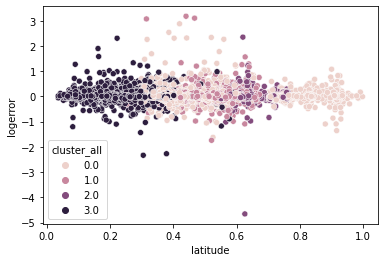

In [47]:
sns.scatterplot(x=X.latitude, y=y_train.logerror, hue=(X.cluster_all))

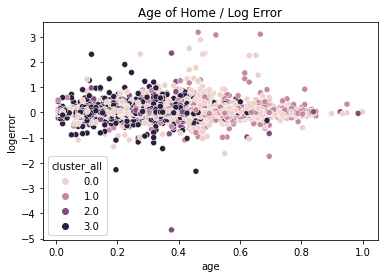

In [48]:
sns.scatterplot(x=X.age, y=y_train.logerror, hue=(X.cluster_all))
sns.color_palette("husl", 8)
plt.title('Age of Home / Log Error')
plt.show()

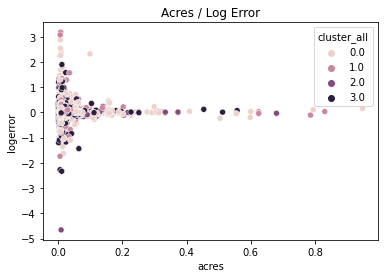

In [49]:
sns.scatterplot(x=X.acres, y=y_train.logerror, hue=(X.cluster_all))
sns.color_palette("husl", 8)
plt.title('Acres / Log Error')
plt.show()

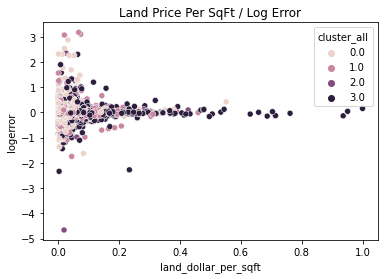

In [50]:
sns.scatterplot(x=X.land_dollar_per_sqft, y=y_train.logerror, hue=(X.cluster_all))
sns.color_palette("husl", 8)
plt.title('Land Price Per SqFt / Log Error')
plt.show()

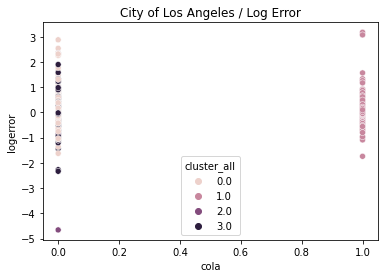

In [51]:
sns.scatterplot(x=X.cola, y=y_train.logerror, hue=(X.cluster_all))
sns.color_palette("husl", 8)
plt.title('City of Los Angeles / Log Error')
plt.show()

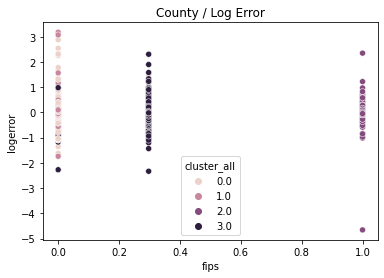

In [52]:
sns.scatterplot(x=X.fips, y=y_train.logerror, hue=(X.cluster_all))
sns.color_palette("husl", 8)
plt.title('County / Log Error')
plt.show()

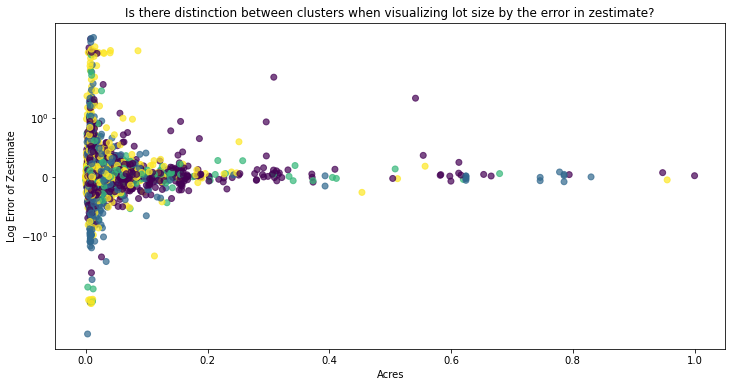

In [53]:
plt.figure(figsize=(12,6))
plt.scatter(y=y_train.logerror, x=X_train.acres, c=X.cluster_all, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Acres')
plt.ylabel('Log Error of Zestimate')
plt.title('Is there distinction between clusters when visualizing lot size by the error in zestimate?')
plt.show()

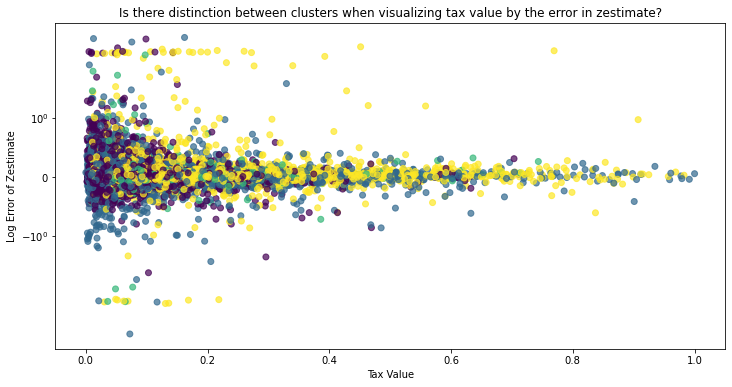

In [54]:
plt.figure(figsize=(12,6))
plt.scatter(y=y_train.logerror, x=X_train.tax_value, c=X.cluster_all, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Tax Value')
plt.ylabel('Log Error of Zestimate')
plt.title('Is there distinction between clusters when visualizing tax value by the error in zestimate?')
plt.show()

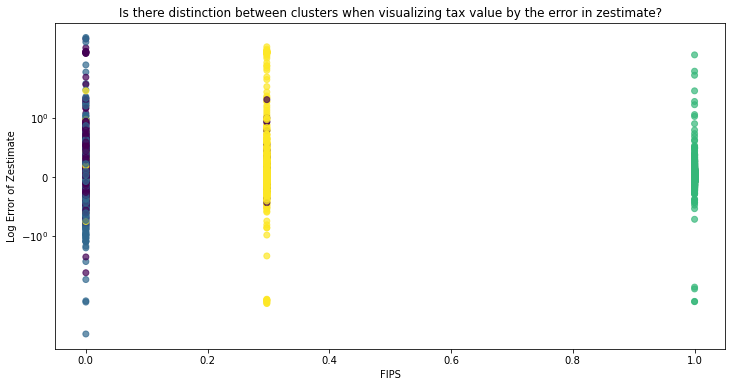

In [55]:
plt.figure(figsize=(12,6))
plt.scatter(y=y_train.logerror, x=X_train.fips, c=X.cluster_all, alpha=.7)
plt.yscale('symlog')
plt.xlabel('FIPS')
plt.ylabel('Log Error of Zestimate')
plt.title('Is there distinction between clusters when visualizing tax value by the error in zestimate?')
plt.show()

## <font color = 'red'> Cluster on Land Columns (size, cost, age)

In [61]:
X1 = X_train[['land_dollar_per_sqft', 'tax_value', 'age']]
X2 = X_validate[['land_dollar_per_sqft', 'tax_value', 'age']]
X3 = X_test[['land_dollar_per_sqft', 'tax_value', 'age']]
# Make the kmeans object
kmeans = KMeans(n_clusters=5)

# fit the kmeans model
kmeans.fit(X1)

# use the thing
kmeans.predict(X1)

array([2, 3, 4, ..., 0, 3, 3], dtype=int32)

In [62]:
X_train['cluster_sca'] = kmeans.predict(X1)
X_validate['cluster_sca'] = kmeans.predict(X2)
X_test['cluster_sca'] = kmeans.predict(X3)

In [63]:
sca_centers=kmeans.cluster_centers_

In [64]:
X_train.head(1)

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all,cluster_sca
0,0.25,0.333333,0.185293,0.297297,0.339753,0.875389,0.253623,0.054803,0.102699,0.084951,0.077757,0.004135,0.061088,0.069281,0.22619,0.0,3,2


## <font color = 'red'> Cluster on Location Columns (latitude, longitude, cola, fips)

In [65]:
X1 = X_train[['latitude', 'longitude', 'cola', 'fips']]
X2 = X_validate[['latitude', 'longitude', 'cola', 'fips']]
X3 = X_test[['latitude', 'longitude', 'cola', 'fips']]
# Make the kmeans object
kmeans = KMeans(n_clusters=3)

# fit the kmeans model
kmeans.fit(X1)

# use the thing
kmeans.predict(X1)

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

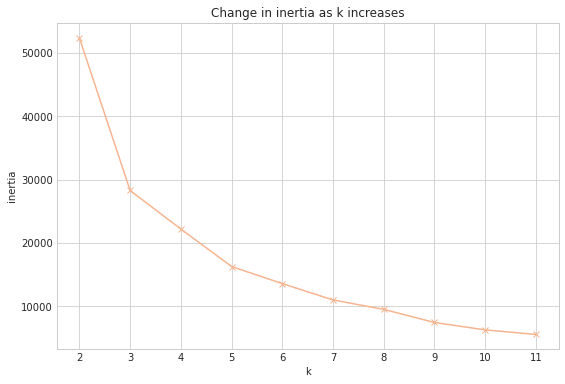

In [66]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [69]:
X_train['cluster_location'] = kmeans.predict(X1)
X_validate['cluster_location'] = kmeans.predict(X2)
X_test['cluster_location'] = kmeans.predict(X3)

In [70]:
loc_centers= kmeans.cluster_centers_

<AxesSubplot:xlabel='cluster_location', ylabel='logerror'>

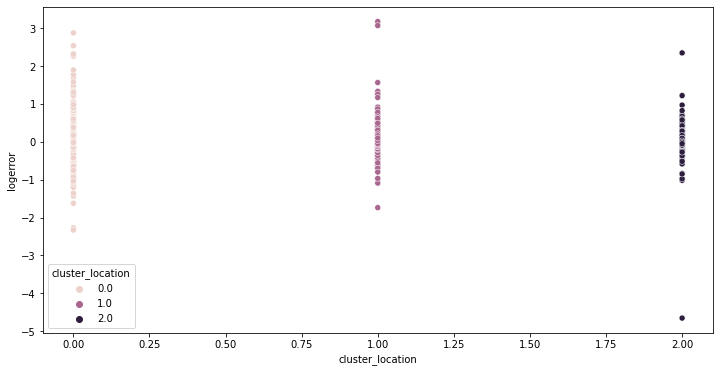

In [71]:
plt.figure(figsize=(12,6))
p= sns.scatterplot(x=X_train.cluster_location, y=y_train.logerror, hue=X_train.cluster_location)
p

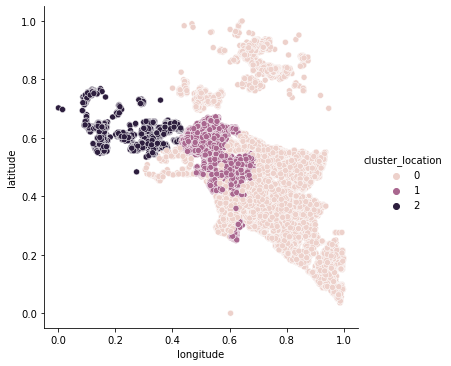

In [72]:
sns.relplot(x="longitude", y="latitude", hue="cluster_location", data=X_train)

## <font color = 'red'> Cluster on Tax (structure_tax_value, land_tax_value, taxamount)

In [73]:
X1 = X_train[['structure_tax_value', 'land_tax_value', 'taxamount']]
X2 = X_validate[['structure_tax_value', 'land_tax_value', 'taxamount']]
X3 = X_test[['structure_tax_value', 'land_tax_value', 'taxamount']]

# Make the kmeans object
kmeans = KMeans(n_clusters=5)

# fit the kmeans model
kmeans.fit(X1)

# use the thing
kmeans.predict(X1)

array([4, 4, 3, ..., 1, 0, 4], dtype=int32)

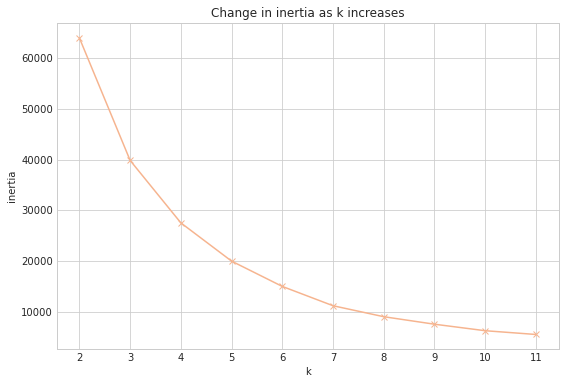

In [74]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [75]:
X_train['cluster_tax'] = kmeans.predict(X1)
X_validate['cluster_tax'] = kmeans.predict(X2)
X_test['cluster_tax'] = kmeans.predict(X3)

In [76]:
kmeans.cluster_centers_

array([[0.11609905, 0.14460291, 0.15405912],
       [0.03122188, 0.01988503, 0.03274079],
       [0.34835961, 0.53078166, 0.51858105],
       [0.19990008, 0.27996554, 0.28290539],
       [0.05767101, 0.07737942, 0.08161512]])

In [77]:
X_train.head(1)

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all,cluster_sca,cluster_location,cluster_tax
0,0.25,0.333333,0.185293,0.297297,0.339753,0.875389,0.253623,0.054803,0.102699,0.084951,0.077757,0.004135,0.061088,0.069281,0.22619,0.0,3,2,0,4


 ## <font color = 'red'> Cluster on Misc (age, acres, structure_dollar_per_sqft)

In [78]:
X1 = X_train[['age', 'acres', 'structure_dollar_per_sqft']]
X2 = X_validate[['age', 'acres', 'structure_dollar_per_sqft']]
X3 = X_test[['age', 'acres', 'structure_dollar_per_sqft']]
# Make the kmeans object
kmeans = KMeans(n_clusters=5)

# fit the kmeans model
kmeans.fit(X1)

# use the thing
kmeans.predict(X1)

array([3, 1, 0, ..., 2, 1, 4], dtype=int32)

In [79]:
X_train['cluster_misc'] = kmeans.predict(X1)
X_validate['cluster_misc'] = kmeans.predict(X2)
X_test['cluster_misc'] = kmeans.predict(X3)

In [80]:
kmeans.cluster_centers_

array([[0.10329852, 0.0173249 , 0.10171493],
       [0.47722271, 0.01248977, 0.06071215],
       [0.67453463, 0.01011654, 0.0626726 ],
       [0.23923215, 0.01701596, 0.07731145],
       [0.37033869, 0.01251742, 0.05853921]])

In [81]:
X_train.head(1)

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all,cluster_sca,cluster_location,cluster_tax,cluster_misc
0,0.25,0.333333,0.185293,0.297297,0.339753,0.875389,0.253623,0.054803,0.102699,0.084951,0.077757,0.004135,0.061088,0.069281,0.22619,0.0,3,2,0,4,3


In [82]:
clusters= X_train[['cluster_all','cluster_sca','cluster_location', 'cluster_tax', 'cluster_misc']]
clusters.head(3)

,cluster_all,cluster_sca,cluster_location,cluster_tax,cluster_misc
0,3,2,0,4,3
1,0,3,0,4,1
2,3,4,0,3,0


# Hypothesis Testing

𝐻0 : A properties land features has no correlation with log error.<br>
𝐻𝑎 : Properties with 

In [ ]:
alpha = 0.05
null_hypothesis = "There is no correlation between city and log error."

F, p = stats.f_oneway(train[train.cluster_tax == 0].log_error,
                      train[train.cluster_tax == 1].log_error,
                      train[train.cluster_tax == 2].log_error,
                      train[train.cluster_tax == 3].log_error)

if p >  α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

print('Anova Test Results on Tax Cluster')
print('F-value:',F)
print('P-value:',p)

# Modeling

### Creating a Baseline

In [ ]:
# 1. Predict logerror_mean
logerror_pred_mean = y_train.logerror.mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_logerrorpred_median
logerror_pred_median = y_train.logerror.median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of tax_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean) ** (1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

# 4. RMSE of tax_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median) ** (1/2)
rmse_validate_baseline = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median) ** (1/2)
print("RMSE using Median\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate_baseline)

In [ ]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

#### Linear Regression Model (OLS Regressor)

In [ ]:
y_validate.shape, y_train.shape, y_test.shape

In [ ]:
# make the thing
# 
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

lm.fit(X_train, y_train.logerror)

# predict train
# 
# use the thing!
# 
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)
metric_df

#### Lasso Lars

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
metric_df = metric_df.append({
    'model': 'Lasso Lars', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)
metric_df

#### Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree = pf.transform(X_validate_scaled)
X_test_degree =  pf.transform(X_test_scaled)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
metric_df = metric_df.append({
    'model': 'Quadratic Model', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)
metric_df

## Modeling using different features

In [ ]:
X_train_features1 = X_train_scaled[['cluster_sca']]
X_train_features2 = X_train_scaled[['cluster_location']]
X_train_features3 = X_train_scaled[['cluster_tax']]
X_train_features4 = X_train_scaled[['cluster_misc']]


X_validate_features1 = X_validate_scaled[['cluster_sca']]
X_validate_features2 = X_validate_scaled[['cluster_location']]
X_validate_features3 = X_validate_scaled[['cluster_tax']]
X_validate_features4 = X_validate_scaled[['cluster_misc']]

X_test_features1 = X_test_scaled[['cluster_sca']]
X_test_features2 = X_test_scaled[['cluster_location']]
X_test_features3 = X_test_scaled[['cluster_tax']]
X_test_features4 = X_test_scaled[['cluster_misc']]

Baseline

RMSE using Mean
Train/In-Sample:  0.16471743733642322  <br>
Validate/Out-of-Sample:  0.16847821920209324 <br>
RMSE using Median
Train/In-Sample:  0.165016885314455 <br>
Validate/Out-of-Sample:  0.16880432248345412 <br>

In [ ]:
# create the model object
# 
# make the thing
# 
# Fit Model
lm.fit(X_train_features1, y_train.logerror)

# Make Predictions
lm_pred = lm.predict(X_train_features1)



# predict train
# 
# use the thing!
# 
y_train['logerror_pred_sca_lm'] = lm.predict(X_train_features1)

# evaluate: rmse
rmse_train_sca = mean_squared_error(y_train.logerror, y_train.logerror_pred_sca_lm) ** (1/2)

# predict validate
y_validate['logerror_pred_sca_lm'] = lm.predict(X_validate_features1)

# evaluate: rmse
rmse_validate_sca = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_sca_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_sca, 
      "\nValidation/Out-of-Sample: ", rmse_validate_sca)

In [ ]:
# create the model object
# 
# make the thing
# 
# Fit Model
lm.fit(X_train_features2, y_train.logerror)

# Make Predictions
lm_pred = lm.predict(X_train_features2)



# predict train
# 
# use the thing!
# 
y_train['logerror_pred_loc_lm'] = lm.predict(X_train_features2)

# evaluate: rmse
rmse_train_loc = mean_squared_error(y_train.logerror, y_train.logerror_pred_loc_lm) ** (1/2)

# predict validate
y_validate['logerror_pred_loc_lm'] = lm.predict(X_validate_features2)

# evaluate: rmse
rmse_validate_loc = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_loc_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_loc, 
      "\nValidation/Out-of-Sample: ", rmse_validate_loc)

In [ ]:
# create the model object
# 
# make the thing
# 
# Fit Model
lm.fit(X_train_features3, y_train.logerror)

# Make Predictions
lm_pred = lm.predict(X_train_features3)


# predict train
# 
# use the thing!
# 
y_train['logerror_pred_tax_lm'] = lm.predict(X_train_features3)

# evaluate: rmse
rmse_train_tax = mean_squared_error(y_train.logerror, y_train.logerror_pred_tax_lm) ** (1/2)

# predict validate
y_validate['logerror_pred_tax_lm'] = lm.predict(X_validate_features3)

# evaluate: rmse
rmse_validate_tax = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_tax_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_tax, 
      "\nValidation/Out-of-Sample: ", rmse_validate_tax)

In [ ]:
# create the model object
# 
# make the thing
# 
# Fit Model
lm.fit(X_train_features4, y_train.logerror)

# Make Predictions
lm_pred = lm.predict(X_train_features4)


# predict train
# 
# use the thing!
# 
y_train['logerror_pred_misc_lm'] = lm.predict(X_train_features4)

# evaluate: rmse
rmse_train_misc = mean_squared_error(y_train.logerror, y_train.logerror_pred_misc_lm) ** (1/2)

# predict validate
y_validate['logerror_pred_misc_lm'] = lm.predict(X_validate_features4)

# evaluate: rmse
rmse_validate_misc = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_misc_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_misc, 
      "\nValidation/Out-of-Sample: ", rmse_validate_misc)

In [ ]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate_baseline': rmse_validate_baseline,
    'model': 'linear_regression',
    'RMSE_validate SCA': rmse_validate_sca,
   'RMSE_validate LOC': rmse_validate_loc,
    'RMSE_validate Tax': rmse_validate_tax,
    'RMSE_validate Misc': rmse_validate_misc
    }])

In [ ]:
metric_df

### Lasso Lars

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_features1, y_train.logerror)

# predict train
y_train['logerror_pred_sca_lars'] = lars.predict(X_train_features1)

# evaluate: rmse
rmse_train_sca = mean_squared_error(y_train.logerror, y_train.logerror_pred_sca_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_sca_lars'] = lars.predict(X_validate_features1)

# evaluate: rmse
rmse_validate_sca = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_sca_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_sca, 
      "\nValidation/Out-of-Sample: ", rmse_validate_sca)

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, loc
# since we have converted it to a dataframe from a series!
lars.fit(X_train_features2, y_train.logerror)

# predict train
y_train['logerror_pred_loc_lars'] = lars.predict(X_train_features2)

# evaluate: rmse
rmse_train_loc = mean_squared_error(y_train.logerror, y_train.logerror_pred_loc_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_loc_lars'] = lars.predict(X_validate_features2)

# evaluate: rmse
rmse_validate_loc = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_loc_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_loc, 
      "\nValidation/Out-of-Sample: ", rmse_validate_loc)

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, loc
# since we have converted it to a dataframe from a series!
lars.fit(X_train_features3, y_train.logerror)

# predict train
y_train['logerror_pred_tax_lars'] = lars.predict(X_train_features3)

# evaluate: rmse
rmse_train_tax = mean_squared_error(y_train.logerror, y_train.logerror_pred_tax_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_tax_lars'] = lars.predict(X_validate_features3)

# evaluate: rmse
rmse_validate_tax = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_tax_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_tax, 
      "\nValidation/Out-of-Sample: ", rmse_validate_tax)

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, loc
# since we have converted it to a dataframe from a series!
lars.fit(X_train_features4, y_train.logerror)

# predict train
y_train['logerror_pred_misc_lars'] = lars.predict(X_train_features4)

# evaluate: rmse
rmse_train_misc = mean_squared_error(y_train.logerror, y_train.logerror_pred_misc_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_misc_lars'] = lars.predict(X_validate_features4)

# evaluate: rmse
rmse_validate_misc = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_misc_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_misc, 
      "\nValidation/Out-of-Sample: ", rmse_validate_misc)

In [ ]:
metric_df = metric_df.append({
    'model': 'mean_baseline', 
    'RMSE_validate_baseline': rmse_validate_baseline,
    'model': 'lasso LARS',
    'RMSE_validate SCA': rmse_validate_sca,
   'RMSE_validate LOC': rmse_validate_loc,
    'RMSE_validate Tax': rmse_validate_tax,
    'RMSE_validate Misc': rmse_validate_misc}, ignore_index=True)
metric_df

#### Polynomial Regression

X_train_features1 = X_train_scaled[['cluster_sca']]
X_train_features2 = X_train_scaled[['cluster_location']]
X_train_features3 = X_train_scaled[['cluster_tax']]
X_train_features4 = X_train_scaled[['cluster_misc']]

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree = pf.fit_transform(X_train_features1)

# transform X_validate_scaled & X_test_scaled
X_validate_degree = pf.transform(X_validate_features1)
X_test_degree =  pf.transform(X_test_features1)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_features1, y_train.logerror)

# predict train
y_train['logerror_pred_sca_lm2'] = lm2.predict(X_train_features1)

# evaluate: rmse
rmse_train_sca = mean_squared_error(y_train.logerror, y_train.logerror_pred_sca_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_sca_lm2'] = lm2.predict(X_validate_features1)

# evaluate: rmse
rmse_validate_sca = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_sca_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_sca, 
      "\nValidation/Out-of-Sample: ", rmse_validate_sca)

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree = pf.fit_transform(X_train_features2)

# transform X_validate_scaled & X_test_scaled
X_validate_degree = pf.transform(X_validate_features2)
X_test_degree =  pf.transform(X_test_features2)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_features1, y_train.logerror)

# predict train
y_train['logerror_pred_loc_lm2'] = lm2.predict(X_train_features2)

# evaluate: rmse
rmse_train_loc = mean_squared_error(y_train.logerror, y_train.logerror_pred_loc_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_loc_lm2'] = lm2.predict(X_validate_features2)

# evaluate: rmse
rmse_validate_loc = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_loc_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_loc, 
      "\nValidation/Out-of-Sample: ", rmse_validate_loc)

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree = pf.fit_transform(X_train_features3)

# transform X_validate_scaled & X_test_scaled
X_validate_degree = pf.transform(X_validate_features3)
X_test_degree =  pf.transform(X_test_features3)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_features1, y_train.logerror)

# predict train
y_train['logerror_pred_tax_lm2'] = lm2.predict(X_train_features3)

# evaluate: rmse
rmse_train_tax = mean_squared_error(y_train.logerror, y_train.logerror_pred_tax_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_tax_lm2'] = lm2.predict(X_validate_features3)

# evaluate: rmse
rmse_validate_tax = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_tax_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_tax, 
      "\nValidation/Out-of-Sample: ", rmse_validate_tax)

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree = pf.fit_transform(X_train_features4)

# transform X_validate_scaled & X_test_scaled
X_validate_degree = pf.transform(X_validate_features4)
X_test_degree =  pf.transform(X_test_features4)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_features4, y_train.logerror)

# predict train
y_train['logerror_pred_misc_lm2'] = lm2.predict(X_train_features4)

# evaluate: rmse
rmse_train_misc = mean_squared_error(y_train.logerror, y_train.logerror_pred_misc_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_misc_lm2'] = lm2.predict(X_validate_features4)

# evaluate: rmse
rmse_validate_misc = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_misc_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_misc, 
      "\nValidation/Out-of-Sample: ", rmse_validate_misc)

In [ ]:
metric_df = metric_df.append({
    'model': 'mean_baseline', 
    'RMSE_validate_baseline': rmse_validate_baseline,
    'model': 'Polynomial',
    'RMSE_validate SCA': rmse_validate_sca,
   'RMSE_validate LOC': rmse_validate_loc,
    'RMSE_validate Tax': rmse_validate_tax,
    'RMSE_validate Misc': rmse_validate_misc}, ignore_index=True)
metric_df

<a id='Model'></a>

## Model

[back to top](#back)

<a id='Concl'></a>

## Conclusion

[back to top](#back)